# 실습. RNN 학습시켜보기 2

<h2>0. Intro</h2>

앞서 살펴본 실습처럼, 본 문제에서는 수열 분류 문제를 다뤄보도록 할 것이다. 본 연습문제에서 다루고자 하는 문제는 아래와 같다.

<center>수열을 절반으로 나눴을 때, 앞부분과 뒷부분이 일치하는가?

간단한 예시를 통해 문제를 이해해보도록 하자.

예를 들어, [1, 2, 3, 1, 2, 3]의 경우 절반으로 나눴을 때, 앞부분인 [1, 2, 3]과 뒷부분인 [1, 2, 3]은 동일하다고 할 수 있다. 그러나 [1, 9, 2, 1, 8, 3]의 경우에는 앞부분인 [1, 9, 2]와 뒷부분인 [1, 8, 3]은 동일하다고 할 수 없다.

이 분류 문제를 조금 다른 관점에서 바라보면, ‘어떠한 수열을 동일한 수열 두 개를 이어붙인 형태라고 할 수 있는가?’ 라고 볼 수 있을 것이다.

우리는 본 연습문제를 통해 최종적으로 특정 수열을 입력받았을 때, 주어진 분류 문제에 맞게 수열을 올바르게 분류할 수 있는 신경망 모델을 구축해낼 것이다. 본 문제는 신경망 모델 정의, 데이터셋 생성, 훈련, 정확도 측정의 순서로 구성되었다. 순서대로 신경 모델을 학습시켜보고, 모델의 정확한지 정확도 측정까지 진행해볼 수 있도록 하자.

시작에 앞서, 본 문제를 해결하는데 필요한 라이브러리들을 import하도록 하자.

In [1]:
from collections import defaultdict

import numpy as np

import torch
import torch as tc
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

%matplotlib inline
import matplotlib.pyplot as plt

<h2>1. One-Hot 인코딩</h2>

이제 신경망 모델을 정의해볼 것이다. 모델을 정의하기에 앞서, 모델이 어떤 형태의 값을 입력받아서 어떤 형태의 값을 출력하게 될 것인지에 대한 논의이 필요할 것이다. 뿐만 아니라 입력받은 값을 신경망 내에서 어떠한 방식으로 처리할 것인지에 대한 논의를 거쳐야 할 것이다. 이들에 대한 간단한 논의를 진행한 후, 모델을 구성해볼 수 있도록 하자.

우선, 신경망은 수열 $(\overrightarrow{x_t})^T_{t=1}$를 입력받을 것이다. 이 수열은 우리가 분류하고자 하는 길이 T의 수열에 One-hot 인코딩이 이루어진 (T, C) 모양의 배열이다. 여기서 T는 수열의 길이, C는 원소가 임베딩된 차원을 지칭한다. 이어 분류의 가짓수가 총 K개 존재한다면, 신경망은 결과 값으로 K개의 분류 점수를 출력할 것이다. 본 문제에서는 ‘yes or no' 2가지가 있으므로 K=2라고 할 수 있다.

**Note** : 정수로 구성된 수열을 One-hot 인코딩한다면 어떠한 형태를 띠게 되는가?
0~9까지의 각 정수는 One-hot 인코딩을 통해 길이 10의 배열로 변형된다.

* 0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
* 1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
* 2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

  ⦙  


* 9 -> [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

아래의 예시를 통해 직관적인 이해를 도모해보자.

In [2]:
# 길이가 4인 정수로 구성된 수열
np.array([2, 0, 2, 0])

# 위 수열이 one-hot 인코딩된 결과는 아래와 같다.

# (4, 10) 모양
np.array([[ 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
[ 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
[ 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
[ 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

위 예시와 같은 방식으로, 길이 T의 수열에 있는 T개의 정수가 각각 길이 C의 배열로 변환된다. 이렇게 우리는 One-hot 인코딩을 통해 $(T, C)_{C=10}$모양의 배열을 출력받게 될 것이다.

<h2>2. 신경망 모델 파헤쳐보기</h2>

그러면 이제 이 입력받은 배열을 가지고 어떻게 가공할 것인지 살펴보자. 살펴보기 전에, 위에 제시한 분류 문제를 컴퓨터의 관점에 맞춰 이진 분류 형식으로 조금 변형해보겠다. 우리가 다루게 될 문제를 이진 분류 문제로 표현해보면, 아래와 같다.

주어진 수열을 절반으로 나눈 뒤, 앞부분과 뒷부분이 같다면 1, 다르다면 0을 출력한다.

최종적으로, 0 아니면 1의 값을 결과 값으로 출력하게 되는 것이다. 이와 같은 값을 최종적으로 출력하기 위해서 신경망이 입력 값을 가공하는 과정을 아래에 수식으로 표현해보았다.


$$\overrightarrow{h_t}=ReLU(\overrightarrow{x_t}W_{xh}+\overrightarrow{h_{t-1}}W_{hh}+\overrightarrow{b_h})$$
$$\overrightarrow{y_t}=\overrightarrow{h_t}W_{hy}+\overrightarrow{b_y}$$

위 식을 이해하기 전에, 우선 각각의 기호가 지칭하는 바가 무엇인지 알아보자.

* $\overrightarrow{h_t}$는 hidden state를 말하고, $\overrightarrow{x_t}$는 수열의 t번째 원소에 대응되는 배열을 나타낸다. (t = 1, 2, 3, …, T, T는 수열의 길이) 그리고 수열 $\overrightarrow{y_t}$은 결과 값인 분류 점수다. 위 식을 보면, t가 1, 2, 3, …, T일 경우 모두에 대한 각각의 결과 값을 계산한다는 것을 알 수 있다. 그러나 본 문제의 경우, 가장 마지막에 출력되는 최종적인 결과 값, $\overrightarrow{y_T}$만 고려할 것이다. 그리고 $\overrightarrow{b_h}$와 $\overrightarrow{b_y}$는 신경망의 매개변수로서 신경망이 학습하는 과정에서 지속적으로 조정될 것이다. 각 기호들에 대해 조금 더 구체적으로 풀어서 설명해보자면 아래와 같다.

* $\overrightarrow{x_t}$는 수열의 t번째 원소를 One-hot 인코딩한 배열로, (1, C)의 모양을 갖는다.

* $\overrightarrow{h_t}$는 “hidden descriptor”로서 $\overrightarrow{x_t}$의 정보와 앞 원소들에 대한 정보 $\overrightarrow{h_{t-1}}$을 내포하고 있으며, (1, D)의 모양을 가진다. D의 값은 우리가 임의로 정할 수 있으며, 이 값은 신경망 내 층의 크기를 나타낸다.

* $W_{xh}$와 $\overrightarrow{b_h}$는 밀집층의 가중치와 편향을 나타내며, 입력 값 $\overrightarrow{x_t}$을 받아서 hidden state $\overrightarrow{h_t}$를 계산하는 데 쓰인다. $W_{xh}$는 (C, D)의 모양을 가지며, $\overrightarrow{b_h}$는 (1, D)의 모양을 갖는다.

* $W_{hh}$ 또한 밀집층의 가중치를 나타내며, 이전 hidden state $\overrightarrow{h_{t-1}}$을 가지고 현재 hidden state $\overrightarrow{h_t}$를 계산하는 데 쓰인다. $W_{hh}$의 경우, (D, D)의 모양을 갖는다.

* $W_{hy}$와 $\overrightarrow{b_y}$도 밀집층의 가중치와 편향을 나타내며, hidden state $\overrightarrow{h_t}$를 이용하여 결과 값인 분류 점수 를 계산하는 데 사용된다. $W_{hy}$는 (D, K)의 모양을 가지며, $\overrightarrow{b_y}$는 (1, K)의 모양을 갖는다. 여기서, K는 분류의 총 가짓수를 말한다. 위에 언급한 바, 이 문제에 한하여 최종 분류 점수에만 관심이 있으므로, 마지막 hidden state $\overrightarrow{h_T}$만을 이용해서 최종 분류 점수 $\overrightarrow{y_T}$를 계산할 것이다.

위와 같이 hidden state와 결과 값을 구하고, 이를 기반으로 다음 hidden state와 결과 값을 구하는 순환적인 구조를 통해 최종 분류 점수를 산출한다. 그리고 구한 최종 분류 점수에 활성화 함수를 적용해서 손실을 계산한다. 이렇게 순전파 과정이 완료된다.

순전파를 진행했다면, 역전파 또한 진행되어야 한다. 역전파를 통해서 gradient 값에 따라 매개변수를 조정하는 과정을 거침으로써 신경망의 학습 과정이 온전히 완료될 것이다. 역전파는 후술할 Adam Optimizer를 통해서 진행될 것이다.

<h2>3. 순환 신경망 모델 구축하기</h2>

자 이제, PyTorch 라이브러리를 이용하여 신경망 모델을 정의해보자. 모델을 구축하는 데 있어서 기반이 되는 식을 아래에 다시 제시해놓겠다.

$$\overrightarrow{h_t}=ReLU(\overrightarrow{x_t}W_{xh}+\overrightarrow{h_{t-1}}W_{hh}+\overrightarrow{b_h})$$
$$\overrightarrow{y_t}=\overrightarrow{h_t}W_{hy}+\overrightarrow{b_y}$$

__ __init__ __

세 개의 값을 입력으로 받는다 : dim_input(C), dim_recurrent(D), dim_output(K)

입력받은 값들을 바탕으로 세 개의 밀집층을 생성한다.

**Note** : 하나의 밀집층에는 편향이 존재하지 않아도 된다. $W_{xh}$와 $W_{hh}$이 하나의 식 안에 존재하기 때문에 두 개의 밀집층에 대해서 편향은 하나만 존재해도 괜찮다.

__ __call__ __

최초의 hidden state $\overrightarrow{h_{t=0}}$가 정의되어 있지 않은 경우, 모든 원소를 0으로 초기화한 (1, D) 모양의 배열로 최초의 hidden state를 생성한다.

입력받은 수열 $(\overrightarrow{x_t})^T_{t=1}$을 가지고 연산을 진행한다. 진행하면서 스텝마다 계산된 hidden state들을 저장해놓는다.

수열에 있는 모든 원소들에 대해 hidden state 계산이 완료되었다면, 저장된 hidden state들을 가지고 각각에 대한 결과 값인 분류 점수를 계산하고 저장해놓는다.

최종적으로 저장된 분류 점수와 hidden state를 리턴한다. 여기서, hidden state는 (T, D)의 모양을 가지고, 분류 점수는 (T, K)의 모양을 갖는다.

**Note** : nn.init.xavier_normal_ 함수를 활용하여 밀집층 최초 생성에 사용하도록 하자.

In [3]:
class RNN(nn.Module):
    """분류 점수와 hidden descriptor를 출력해주는 간단한 RNN을 구현해보자"""

    def __init__(self, dim_input, dim_recurrent, dim_output):
        """ RNN에 필요한 층들을 생성해보자
        매개변수(Parameters)
        ----------
        dim_input: int
        입력받을 데이터의 차원 (C)
        dim_recurrent: int
        RNN에서 쓰일 hidden state의 차원 (D)
        dim_output: int
        RNN에서 출력할 분류 점수의 차원 (K)
        """
        super(RNN, self).__init__()
        self.fc_x2h = nn.Linear(dim_input, dim_recurrent)
        self.fc_h2h = nn.Linear(dim_recurrent, dim_recurrent, bias=False)
        self.fc_h2y = nn.Linear(dim_recurrent, dim_output)
        self.relu = nn.ReLU()

    def forward(self, x, h=None):
        """ RNN의 순전파를 구현해보자.
        비록 최종 분류 점수만을 기반으로 손실함수의 값이 계산되지만,
        전체 수열에 대한 hidden state와 분류 점수들 모두 리턴할 것이다.
        매개변수(Parameters)
        ----------
        x: torch.Tensor, shape=(T, C)
        수열이 One-hot 인코딩된 배열
        h: Optional[torch.Tensor], shape=(1, D)
        최초의 hidden state를 나타낸다.
        입력된 값이 없을 경우 0으로 값이 초기화된 배열로 설정한다.

        반환 값(Returns)
        -------
        Tuple[y, h]
        y: torch.Tensor, shape=(T, K)
        각 스텝마다 계산된 결과 값들(분류 점수)
        h: torch.Tensor, shape=(T, D)
        각 스텝마다 계산된 hidden state들
        """
        # 최초 hidden state 값이 입력되지 않은 경우, 모든 원소를 0으로 초기화한다.
        if h is None:
            h = torch.zeros(1, self.fc_h2h.out_features, device=x.device)

        h_list = []

        # 각 x_t에 대해 대응되는 h_t를 저장해놓도록 하자. (h_0 제외)
        # x_t.unsqueeze(0)는 (C,) 모양의 x_t를 (1, C) 모양으로 바꾸어준다.
        # h는 (1, D) 모양의 hidden descriptor이다.
        # for 문을 이용하여 x 내의 데이터를 한 스텝씩 꺼낸다.
        for x_t in x:
            h = self.relu(self.fc_x2h(x_t) + self.fc_h2h(h))
            h_list.append(h)


        # T개의 descriptor들이 있는 (T, D)모양의 배열 (각 descriptor는 (D,) 모양이다)
        # 즉, RNN의 모든 hidden state를 하나의 행렬로 묶어서 return할 것이다. (torch.cat 기능 사용할 것)
        # https://pytorch.org/docs/stable/generated/torch.cat.html
        all_h = torch.cat(h_list, dim=0)


        # all_y는 T개의 예측 점수가 들어 있는 (T, K) 모양의 배열이다.
        # 각 점수들은 T개의 hidden descriptor로부터 각기 산출된다.
        all_y = self.fc_h2y(all_h)

        return all_y, all_h # 반드시 최종 출력 all_y와 all_h를 둘 다 return해야 한다.

<h2>4. 학습에 사용할 데이터셋 생성</h2>

자, 모델을 정의했으니 학습에 사용할 데이터셋을 만들어보자. 데이터셋이 신경망에 적절히 입력되려면, 어떠한 성질을 갖추어야 할까?

우리가 다루고자 하는 문제는 아래와 같다.

<center>수열을 절반으로 나눴을 때, 앞부분과 뒷부분이 일치하는가?

우선, 우리가 다룰 문제는 수열을 절반으로 나누는 것을 상정하고 있으므로, 입력받을 수열의 길이는 반드시 짝수여야 할 것이다. 우리는 수열을 절반으로 나눈 뒤 앞부분과 뒷부분으로 구분하고, 각 부분을 패턴이라고 통칭할 것이다.

앞부분과 뒷부분이 일치한 수열을 만든다면 동일한 패턴 2개를 이어붙이는 것이고, 앞부분과 뒷부분이 다르다면 서로 다른 패턴 2개를 이어붙이는 것이다. 여기서 패턴의 길이는 수열의 길이의 절반이라고 할 수 있을 것이다.

이외에 데이터셋이 갖추어야 할 성질들을 아래에 쭉 나열해보겠다.

* 패턴 길이의 최솟값과 최댓값을 함수 사용자 임의로 지정할 수 있다.
* 위에서 지정한 범위 내에서 랜덤으로 패턴의 길이를 정한다.
* 위에서 정한 길이만큼 0~9의 정수로 구성된 패턴을 랜덤으로 생성한다.
* 수열의 앞부분에 위에서 생성한 패턴을 넣는다.
* 수열의 앞부분과 뒷부분을 동일하게 할 것인가에 대해 50%의 확률로 결정한다.
* 위에서 결정된 내용을 바탕으로 수열의 뒷부분을 채워 넣는다.
* float32를 타입으로 갖는 (T, 10) 모양의 numpy 배열 x을 만든다. 여기서 i번째 행은 수열의 i번째 항을 one-hot 인코딩한 배열이다.
* int16을 타입으로 갖는 (1, ) 모양의 numpy 배열 y를 만든다. 수열의 앞부분과 뒷부분이 같다면 array([1]), 다르다면 array([0])의 값을 갖는다.
* (x, y, 수열)의 tuple 형식으로 리턴한다.

**Hint** : np.random.rand() < 0.5는 정확히 50% 확률로 True 혹은 False 값을 갖는다.

위 함수의 이해를 돕기 위해, 예시를 들어보겠다. 생성된 수열이 [2, 0, 2, 0]이라고 하자. 이 수열은 절반으로 나눴을 때, 앞부분과 뒷부분이 동일하기 때문에 y는 array([1])일 것이다. 그리고 x의 경우 아래와 같이 표현할 수 있을 것이다.

In [4]:
np.array([[ 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
[ 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
[ 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
[ 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

그리고 수열의 경우, array([2, 0, 2, 0])로 표현될 것이다.

그럼 이제 위에 제시한 설명을 바탕으로 데이터셋을 생성해주는 함수를 구현해보자!

**Note** : 아래의 generate_sequence 함수는 palindrome을 입력받는다. palindrome이란 중앙을 기준으로 대칭인 수열을 나타내며, [1, 2, 3, 3, 2, 1]과 같은 수열이 palindrome의 예시라고 할 수 있다. palindrome=True라고 설정하게 되면, 본 신경망에서 다루는 분류 문제가 달라진다. 원래는 수열의 앞부분과 뒷부분이 일치하는지 따지는 문제였던 반면에, 수열이 palindrome인지 아닌지 따지는 문제로 바뀌게 된다.

In [5]:
def generate_sequence(pattern_length_min=1, pattern_length_max=10, palindrome=False):
    """
    임의로 수열을 생성해보자. 앞부분과 뒷부분은 50%의 확률로 동일할 것이다.
    매개변수(Parameters)
    ----------
    pattern_length_min : int, optional (default=1)
    패턴의 최소 길이
    pattern_length_max : int, optional (default=10)
    패턴의 최대 길이
    palindrome : bool, optional (default=False)
    True일 경우, 앞부분과 뒷부분이 동일한 수열 대신 palindrome인 수열을 생성

    반환 값(Returns)
    -------
    Tuple[torch.Tensor, torch.Tensor, np.ndarray]
    1. (T, 10) 모양으로 수열이 one-hot encoding된 결과
    2. 앞부분과 뒷부분이 동일한지 여부 : 동일하면 1, 아니면 0
    3. (T, ) 모양의 실제 수열
    """
    pattern_length = np.random.randint(pattern_length_min, pattern_length_max + 1)
    pattern = np.random.randint(0, 10, pattern_length)
    match = np.random.rand() >= 0.5

    sequence = np.zeros(2 * pattern_length, dtype=np.int64)
    sequence[:pattern_length] = pattern
    if match:
        sequence[pattern_length:] = pattern[::-1] if palindrome else pattern
    else:
        # 전반부와 후반부가 일치하지 않을 경우
        second_half = np.random.randint(0, 10, pattern_length)
        while np.array_equal(second_half, pattern):
            second_half = np.random.randint(0, 10, pattern_length)
        sequence[pattern_length:] = second_half

    # 0에서 9까지의 숫자들로 one-hot 인코딩 수행
    x = np.zeros((len(sequence), 10), dtype=np.float32)
    y = np.array([1.0 if match else 0], dtype=np.int16)

    for i, ch in enumerate(sequence):
        x[i, ch] = 1

    return torch.tensor(x), torch.tensor(y), sequence

generate_sequence 함수를 의도한 대로 정확히 구현했는지 테스트해보자.

* 입력해준 최소, 최대 범위 내에서 수열이 생성되는가?
* x 값이 실제 수열에 잘 대응되는가? One-hot 인코딩된 결과를 올바르게 표현했는가?
* 분류 문제에 따라 y 값이 적절히 출력되었는가?

위 조건들 중 하나라도 위배할 시 실패했음을 알려주는 간단한 코드를 작성해보자.

In [13]:
x, y, seq = generate_sequence()
print(f"shape of x : {x.shape}")
print(f"x : {x}")
print(f"y : {y}")
print(f"original sequence : {seq}")

shape of x : torch.Size([10, 10])
x : tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
y : tensor([1], dtype=torch.int16)
original sequence : [3 0 2 8 9 3 0 2 8 9]


In [14]:
for i in range(100):
    x, y, seq = generate_sequence()
    assert len(x) == len(seq)
    assert (seq[:len(seq)//2] == seq[-len(seq)//2:]).all() == bool(y.item())
    assert (x[:len(x)//2] == x[-len(x)//2:]).all().item() == bool(y.item())


<h2>5. 신경망 학습시키기</h2>

이제 정의한 모델에 적절한 값을 넣어서 RNN을 구축해보자. 우선. 수열의 각 원소는 One-hot 인코딩되어 있기에 C = 10(input_dim)이다. 그리고 hidden-descriptor의 차원은 D = 50(dim_recurrent)으로 설정하겠다. 마지막으로 우리는 수열의 앞부분과 뒷부분의 일치 여부를 판정하는, 두 가지 중 하나로 분류하는 문제를 다루고 있기 때문에, K = 2(dim_output)으로 설정해준다.

역전파에 사용할 Adam optimizer를 세팅해보자. Adam optimizer에 RNN의 매개변수들을 입력하자.

In [15]:
model = RNN(dim_input=10, dim_recurrent=50, dim_output=2)
optimizer = optim.Adam(model.parameters())

In [16]:
def accuracy(predictions, truth):
    """
    하나의 batch에 대한 모델의 예측값과 실제값을 비교하여, 정확도를 계산하는 함수

    매개변수 (Parameters)
    ----------
    predictions : torch.Tensor, shape=(M, D)
        M은 batch를 구성하는 데이터의 개수, D는 분류할 소용돌이의 개수(이번 실습에서는 3으로 사용)
        Step 3에서 정의한 모델의 forward 메서드에서의 출력 인자 그대로가 이 함수에 전달된다고 생각

    truth : torch.Tensor, shape=(M,)
        batch를 구성하는 각각의 데이터(점)가 실제로 어떤 소용돌이에 포함되는지를 0, 1, ..., D-1의 숫자 중 하나로 나타내어 나열한 것
        예를 들어, batch에 3개의 데이터가 들어있고, 각각이 0번, 1번, 1번 소용돌이에 속한다면 truth는 [0, 1, 1]의 배열

    반환 값 (Returns)
    -------
    float형
        해당 batch에 대한 모델의 분류 정확도, 0 이상 1 이하의 실수값
    """
    predicted_labels = torch.argmax(predictions, axis=1)
    correct = (predicted_labels == truth).float()
    accuracy = correct.mean().item()
    return accuracy


10만 번의 iteration을 통해 학습시켜보자. 사전에 생성된 데이터셋을 가지고 학습하는 방식이 아니라, 모든 iteration마다 generate_sequence를 통해 새로운 데이터를 만들어 입력하는 방식을 취할 것이다. 패턴의 최소 길이는 1, 최대 길이는 10으로 설정해놓도록 하자.

**Note** : 손실을 계산하기 위해 우리는 오직 최종 분류 점수, (1, K) 모양의 만을 넘겨줄 것이다.

In [17]:
from IPython.display import clear_output
def plot_all(losses, acces):
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Loss')
    plt.plot(acces, label='acc')
    plt.xlabel('Epoch (it must multiple x 1000)')
    plt.ylabel('Loss and Acc')
    plt.title('Loss and Acc Averages over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

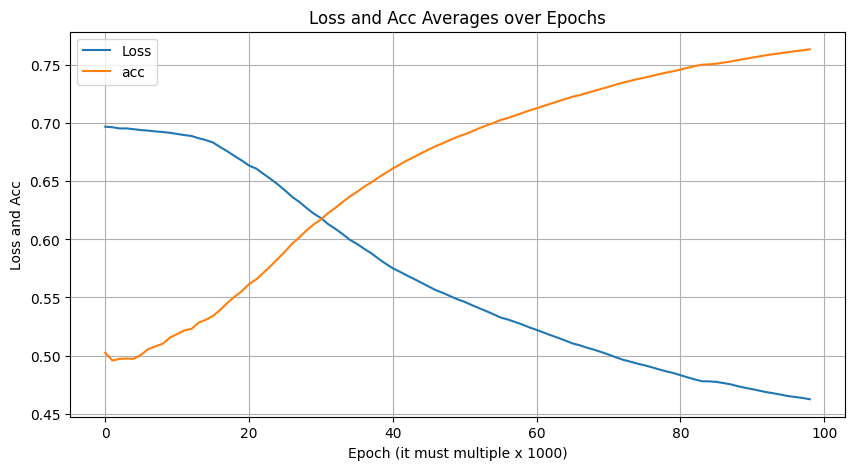

Epoch 99000/100000, Loss: 0.4624, acc : 0.7637599620205856


In [18]:
# 학습 루프
plot_every = 1000
num_epochs = 100000

losses = []
loss_average_list = []
acc_list = []
acc_list_average = []
for epoch in range(num_epochs):
    x, target, sequence = generate_sequence(palindrome=False)

    optimizer.zero_grad() # optimizer 기울기 초기화
    output, _ = model(x) # 은닉층부터 출력층의 가중치 곱까지의 순전파에서 전달되는 값 구하기

    output = output[-1:]
    target = target.long()

    loss = nn.CrossEntropyLoss()(output, target)
    losses.append(loss.item())
    loss.backward() # torch의 자동미분 함수를 활용하여 역전파 진행
    optimizer.step() # optimizer의 한 스텝 진행

    acc = accuracy(output, target)
    acc_list.append(acc)
    if epoch % plot_every == 0 and epoch > 0:
        acc_average = np.mean(acc_list)
        loss_average = np.mean(losses)
        loss_average_list.append(loss_average)
        acc_list_average.append(acc_average)
        plot_all(loss_average_list, acc_list_average)
        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss_average:.4f}, acc : {acc_average}")

<h2>6. 수열의 길이에 따른 정확도 차이</h2>

수열의 길이에 따른 정확도를 plot으로 표현해보자. 우선, 임의로 수열들을 생성하고 학습된 신경망에 입력한 후, 예측 분류 점수를 출력 받는다. 이어서 이 예측이 옳은지 아닌지 기록해 놓는다. 이 때, 수열의 길이가 2인 것, 4인 것 등등 각각에 대한 정확도를 따로 계산한다.

Hint: 임의로 생성된 수열 하나하나에 대한 정확도를 측정해가면서, 수열의 길이 별로 수열의 총 개수와 옳은 예측의 개수를 기록해 놓는다.

**PyTorch Note:** output = model(x)와 같은 형태로 많은 수열들을 가지고 신경망 모델을 평가할 것이기 때문에 torch.no_grad() 설정해주는 것이 중요하다.

**with torch.no_grad:**

위 코드를 통해 pytorch는 빨리 작동할 수 있게 된다.

In [19]:
# 평가
length_total = defaultdict(int)
length_correct = defaultdict(int)

with torch.no_grad():
    for i in range(100000):
        if i % 5000 == 0:
            print(f"{i}번 test 진행")
        if i == (100000-1):
            print(f"{i}번 test 진행")
        x, target, sequence = generate_sequence()

        output, _ = model(x)
        output = output[-1:]

        length_total[len(sequence)] += 1
        if torch.argmax(output.squeeze()) == target.item():
            length_correct[len(sequence)] += 1

0번 test 진행
5000번 test 진행
10000번 test 진행
15000번 test 진행
20000번 test 진행
25000번 test 진행
30000번 test 진행
35000번 test 진행
40000번 test 진행
45000번 test 진행
50000번 test 진행
55000번 test 진행
60000번 test 진행
65000번 test 진행
70000번 test 진행
75000번 test 진행
80000번 test 진행
85000번 test 진행
90000번 test 진행
95000번 test 진행
99999번 test 진행


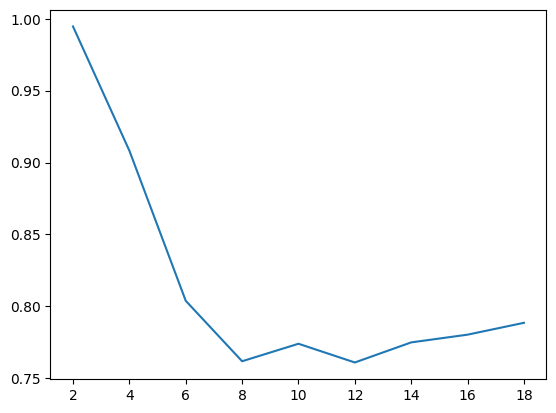

In [20]:
fig, ax = plt.subplots()
x, y = [], []
for i in range(2, 20, 2):
    x.append(i)
    y.append(length_correct[i] / length_total[i])
ax.plot(x, y);

수열의 길이가 증가함에 따라 정확도는 어떤 양상을 보이는가? 무엇이 긴 수열을 다루기 어렵게 만드는가? 한 번 생각해보자.

학습할 때 사용되는 수열들의 길이를 이전보다 길게 했을 때는 어떻게 되는가? palindrome을 분류하는 문제로 바꿔서 데이터셋을 만들고 학습시킨 경우에는 정확도가 어떻게 되는가? 직접 시도해보고, 답을 도출해내보자.

이제 Computational Graph를 통해 순전파가 이루어지는 과정을 살펴보자. Computational Graph는 연산 과정을 시각화해서 보여주는 것으로, 책에 수록된 그림 3.4-7과 같다.